In [9]:
!git clone https://github.com/ch2343/scCRAFT.git

Cloning into 'scCRAFT'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 142 (delta 74), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (142/142), 4.71 MiB | 3.72 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [10]:
%cd scCRAFT
!pip install .

/Users/xiaoyushen/Desktop/biostat/human_immune/scCRAFT
Processing /Users/xiaoyushen/Desktop/biostat/human_immune/scCRAFT
  Preparing metadata (setup.py) ... done
  Using cached scib-1.1.5-1-py3-none-any.whl.metadata (9.8 kB)
  Using cached scikit_misc-0.4.0.tar.gz (302 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [59 lines of output]
      + meson setup /private/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/pip-install-_9xbknum/scikit-misc_5f28996a9d464758b41409bfce2d639b /private/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/pip-install-_9xbknum/scikit-misc_5f28996a9d464758b41409bfce2d639b/.mesonpy-7fwqwyz4 -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=/private/var/folders/6f/wd7m9z0d6wg__mwtlh6

In [11]:
!pip install harmonypy

In [1]:
import scanpy as sc
import numpy as np
# import scCRAFT
# from scCRAFT.model import *
import harmonypy as hm
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import scanorama
import scanpy as sc
import scvi
import seaborn as sns
import torch

/Users/sheena/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

In [3]:
# adata = anndata.read_h5ad("/content/drive/MyDrive/scdata/human_immune/human_immune.h5ad")
adata = anndata.read_h5ad("../human_immune.h5ad")
adata

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [44]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [18]:
embeddings_dict = {}

# Scanorama

In [6]:
import anndata as ad

def split_batches(adata, batch_key, return_categories=False):
    """
    Split an AnnData object into a list of AnnData objects by batch.
    
    Parameters:
    - adata (AnnData): The AnnData object to split.
    - batch_key (str): The key in `adata.obs` used to identify batches.
    - return_categories (bool): Whether to return the unique categories (batch labels).

    Returns:
    - list: A list of AnnData objects, one for each batch.
    - list (optional): A list of unique batch categories, if `return_categories` is True.
    """
    if batch_key not in adata.obs:
        raise ValueError(f"Batch key '{batch_key}' not found in adata.obs.")
    
    categories = adata.obs[batch_key].unique().tolist()
    split_data = [adata[adata.obs[batch_key] == batch].copy() for batch in categories]
    
    if return_categories:
        return split_data, categories
    return split_data

In [7]:
#Scanorama
# Save original order of cells
original_order = adata.obs_names.copy()

# Your existing Scanorama correction process
split, categories = split_batches(adata.copy(), 'batch', return_categories=True)
corrected = scanorama.correct_scanpy(split, return_dimred=True)
corrected = anndata.AnnData.concatenate(
    *corrected, batch_key='batch', batch_categories=categories, index_unique=None
)

# Reorder corrected data to match original order
corrected = corrected[original_order]

# Replace adata with corrected data
adatas = corrected.copy()

Found 2000 genes among all datasets
[[0.00000000e+00 6.35344161e-01 8.66976025e-01 2.36032268e-02
  8.50734725e-03 1.73913043e-03 4.38404209e-04 1.93348801e-02
  2.47933884e-03 3.91389432e-03]
 [0.00000000e+00 0.00000000e+00 6.26033691e-01 3.76456528e-02
  5.20673813e-03 2.31884058e-03 0.00000000e+00 2.49687890e-03
  2.14395100e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.46280251e-01
  1.77211796e-01 1.79710145e-02 3.94563788e-03 1.05898123e-01
  1.84986595e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.06692561e-02 7.00289855e-01 2.94607628e-01 3.83687058e-01
  2.74380165e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.84637681e-01 1.25383604e-01 7.61548065e-02
  3.84297521e-02 2.73972603e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 8.85797101e-01 3.42608696e-01
  2.75362319e-01 9.78473581e-04]
 [0.00000000e+00 0.000

In [9]:
adata.obsm['X_scanorama'] = adatas.obsm['X_scanorama']

embeddings_dict['X_scanorama'] = adata.obsm["X_scanorama"]

In [10]:
embeddings_dict.keys()

dict_keys(['X_scVI', 'X_harmony', 'X_scCRAFT', 'X_seurat', 'X_scanorama'])

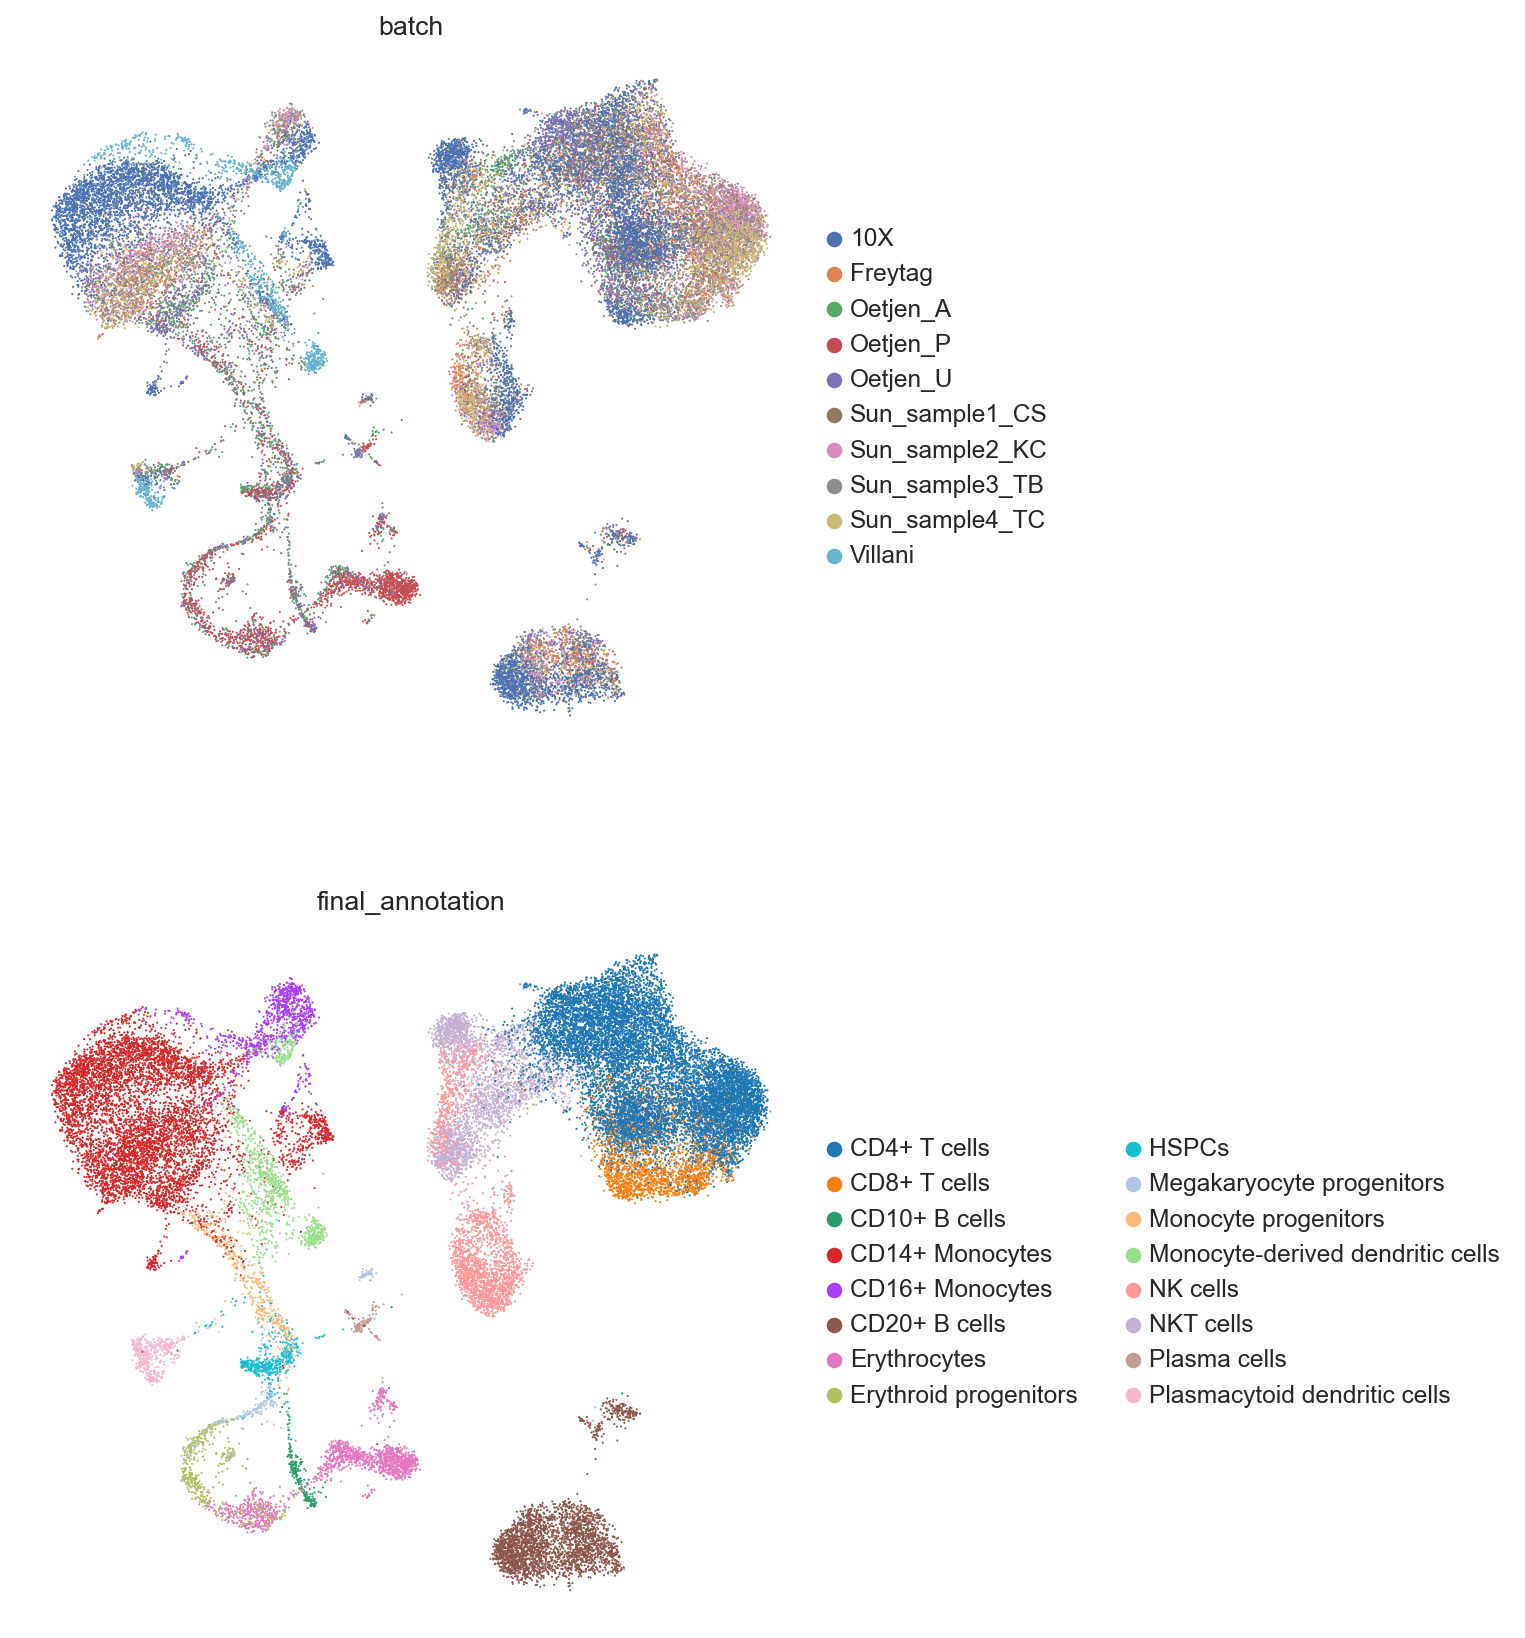

In [11]:
# Umap Plotting
sc.pp.neighbors(adata, n_pcs=30, use_rep="X_scanorama")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["batch", "final_annotation"], frameon=False, ncols=1)

# scCRAFT

In [ ]:
# scCRAFT
multi_resolution_cluster(adata, resolution1 = 0.5, method = 'Leiden')
VAE = train_integration_model(adata, batch_key = 'batch', z_dim=256, d_coef = 0.2)
obtain_embeddings(adata, VAE)
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
sc.tl.umap(adata, min_dist=0.5)

In [ ]:
sc.pl.umap(adata, color=["batch", "final_annotation"], frameon=False, ncols=1)

In [ ]:
# Save embeddings
adata.obsm["X_scCRAFT"] = adata.obsm["X_scCRAFT"]

# Collect embeddings
embeddings_dict = {"X_scCRAFT": adata.obsm["X_scCRAFT"]}

# scVI

In [9]:
# scVI
adata = adata.copy()
# adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 239/239: 100%|█| 239/239 [14:09<00:00,  3.55s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=239` reached.


Epoch 239/239: 100%|█| 239/239 [14:09<00:00,  3.55s/it, v_num=1, train_loss_step


In [20]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

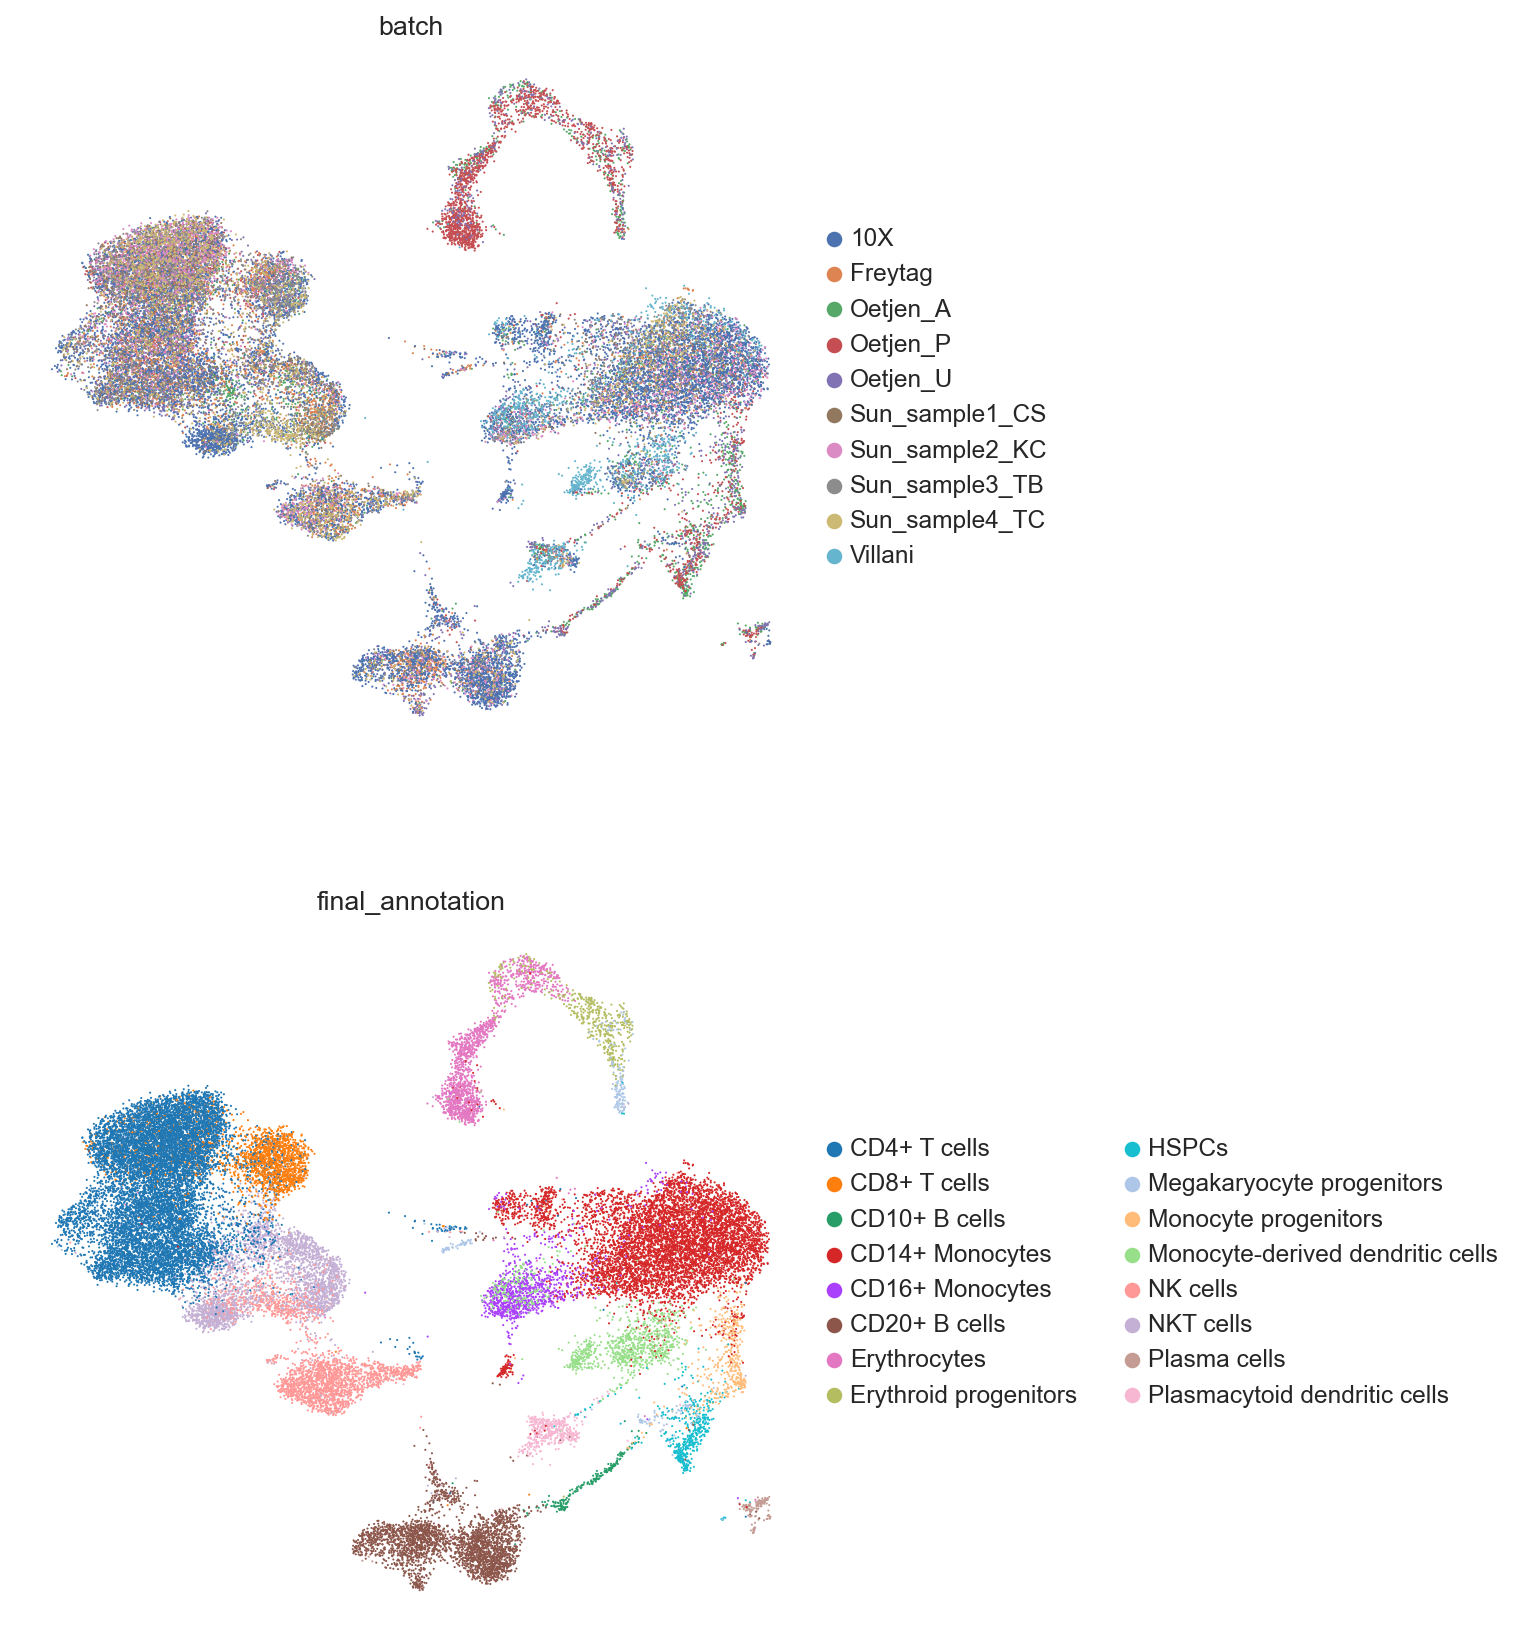

In [22]:
sc.pl.umap(adata, color=["batch", "final_annotation"], frameon=False, ncols=1)

# Harmony

In [25]:
# Harmony
sc.tl.pca(adata, n_comps=50)
data_mat = adata.obsm['X_pca']
meta_data = adata.obs

# Specify the variables to use (as in your original code)
vars_use = ['batch']

# Run Harmony
start_time = time.time()
ho = hm.run_harmony(data_mat, meta_data, vars_use)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Convert the adjusted PCs to a DataFrame
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

# If you want to store the adjusted PCs back into the AnnData object
adata.obsm['X_harmony'] = res.values.T
sc.pp.neighbors(adata, use_rep="X_harmony")
sc.tl.umap(adata, min_dist=0.5)

2024-07-16 09:49:42,697 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-07-16 09:49:51,909 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-07-16 09:49:52,011 - harmonypy - INFO - Iteration 1 of 10
2024-07-16 09:49:58,503 - harmonypy - INFO - Iteration 2 of 10
2024-07-16 09:50:04,350 - harmonypy - INFO - Iteration 3 of 10
2024-07-16 09:50:10,165 - harmonypy - INFO - Iteration 4 of 10
2024-07-16 09:50:13,217 - harmonypy - INFO - Converged after 4 iterations


Training completed in 30.53 seconds


In [26]:
# Save embeddings
adata.obsm["X_harmony"] = adata.obsm["X_harmony"]

# Collect embeddings
embeddings_dict["X_harmony"] = adata.obsm["X_harmony"]

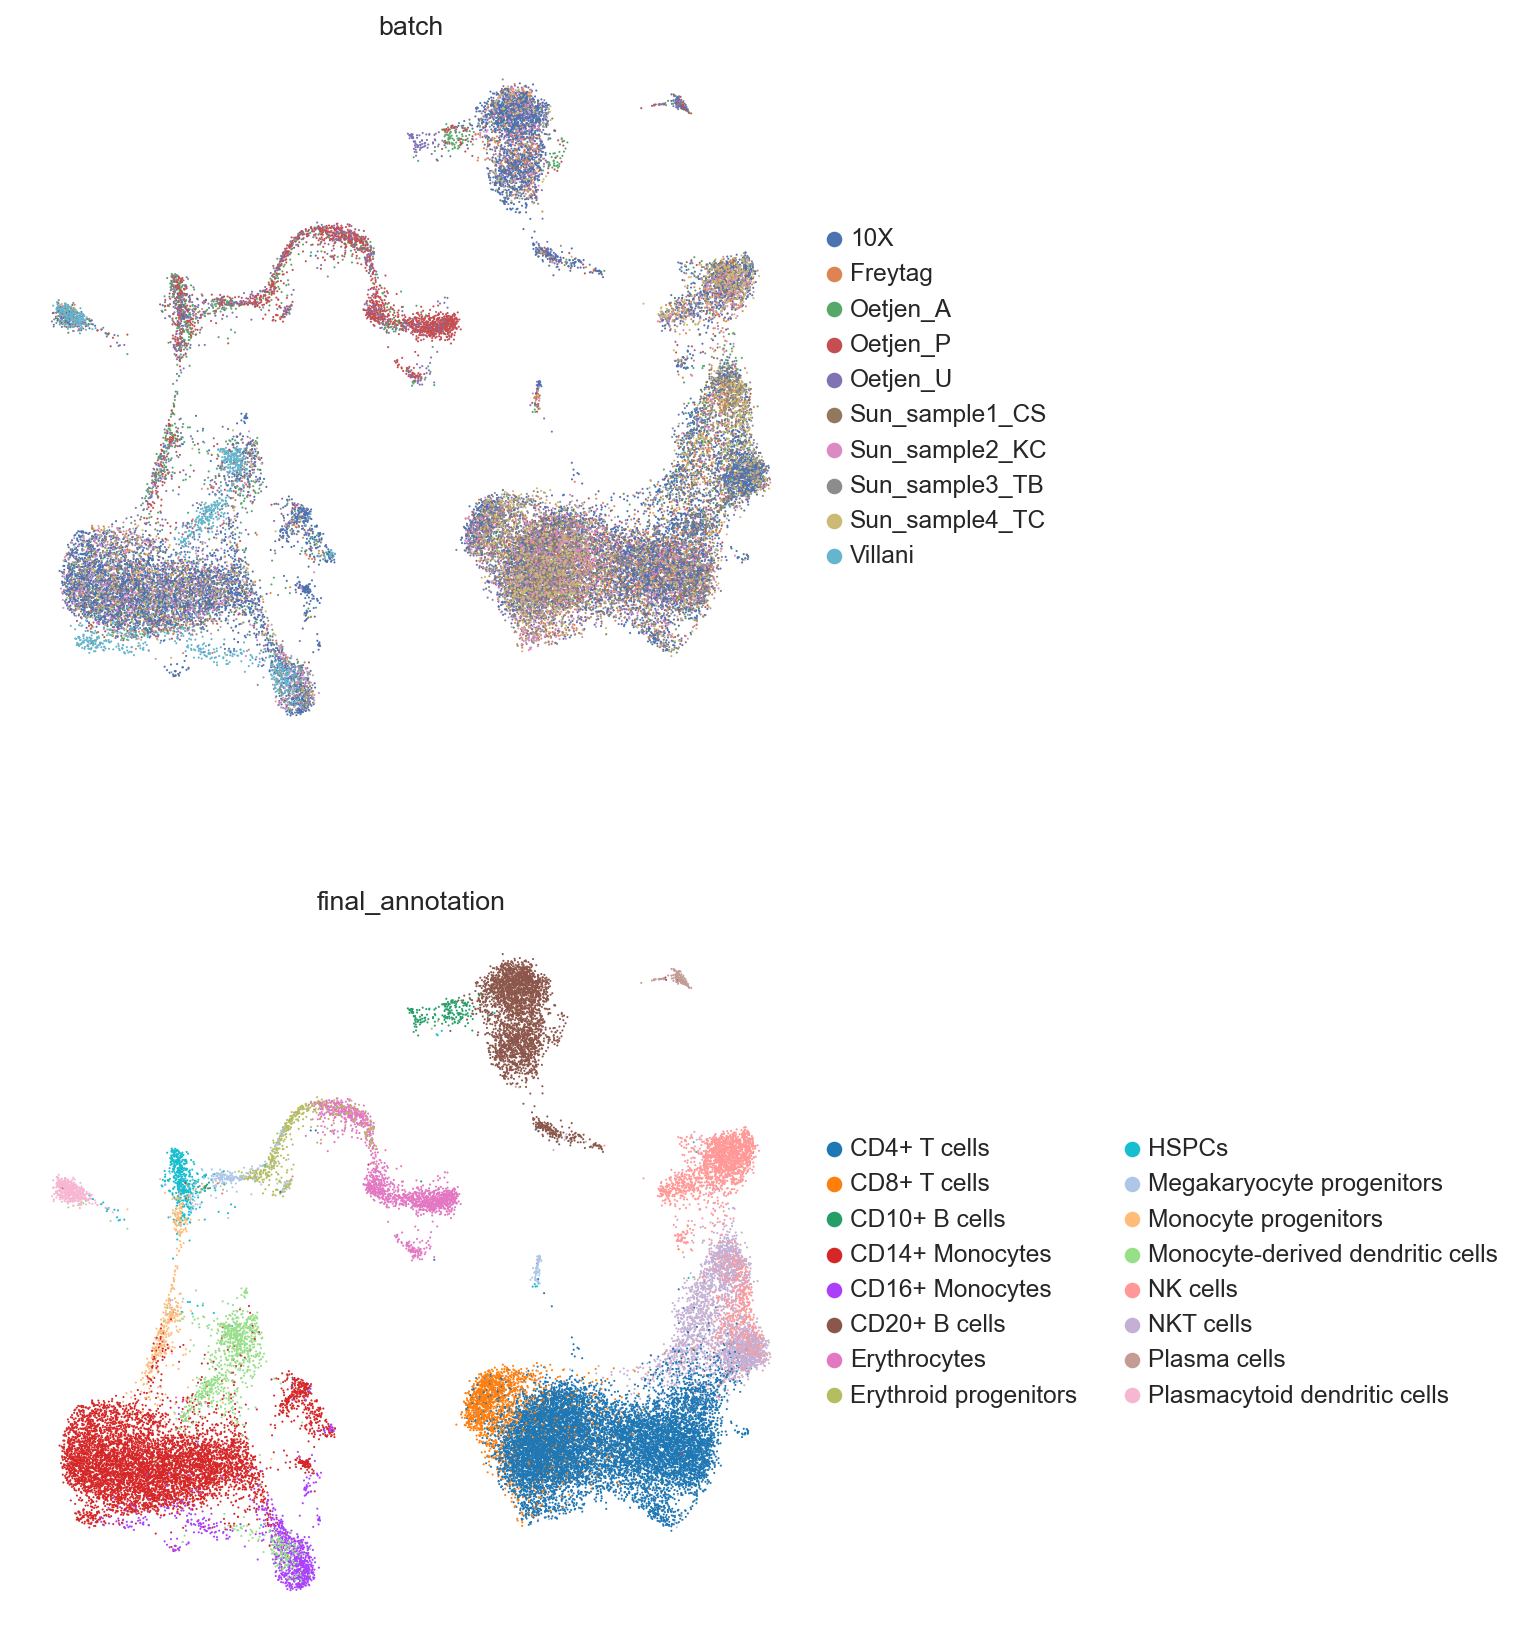

In [27]:
sc.pl.umap(adata, color=["batch", "final_annotation"], frameon=False, ncols=1)

# Seurat

In [47]:
pca_embeddings = pd.read_csv('./human_immune_seurat.csv', index_col=0)
adata.obsm['X_seurat'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_seurat")
sc.tl.umap(adata, min_dist=0.5)

/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_6246/3765706945.py:2: ImplicitModificationWarning: Setting element `.obsm['X_seurat']` of view, initializing view as actual.
  adata.obsm['X_seurat'] = pca_embeddings.values


In [48]:
# Collect embeddings
embeddings_dict["X_seurat"] = adata.obsm["X_seurat"]

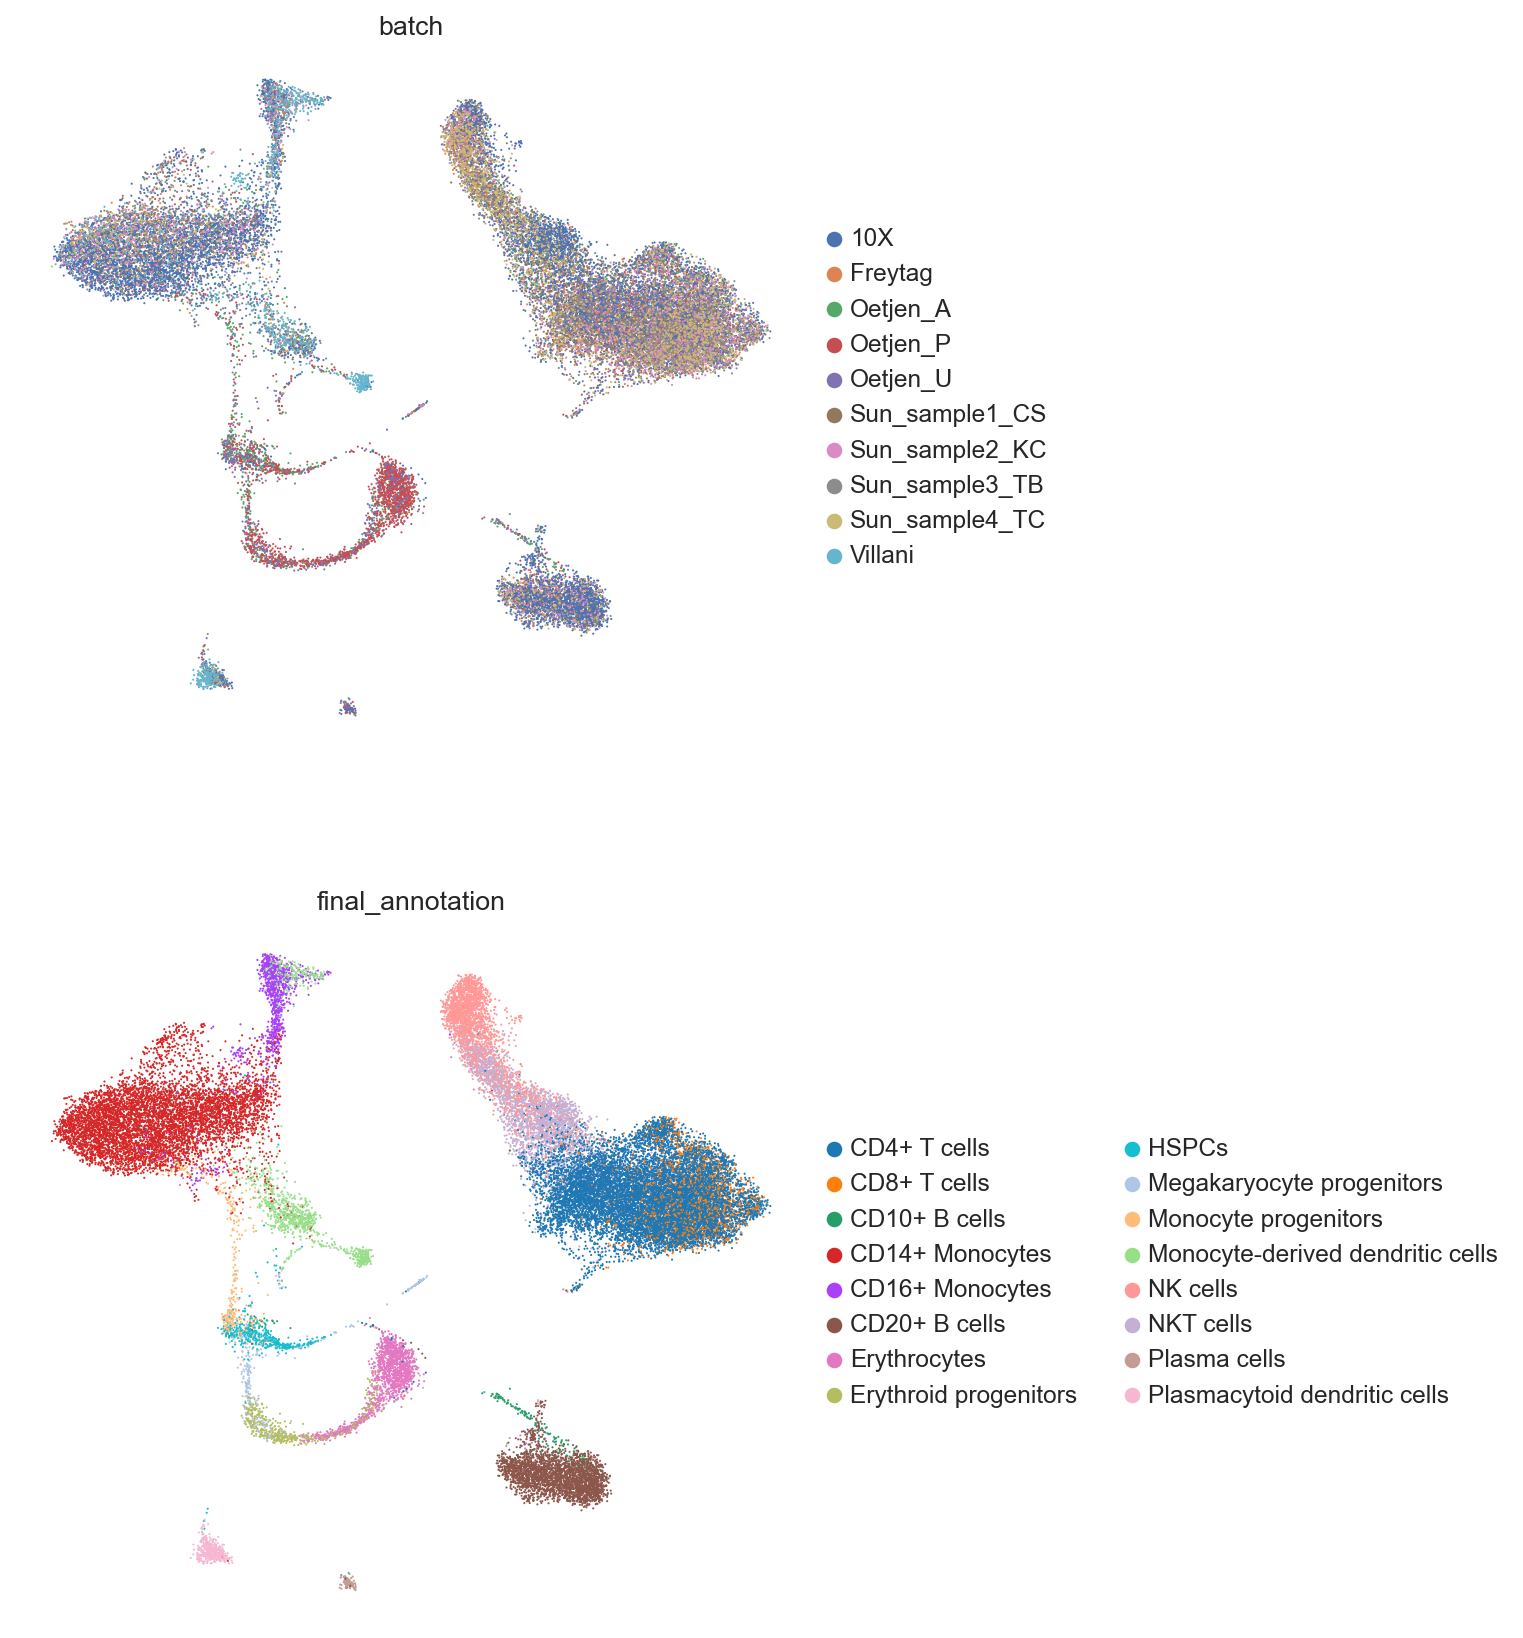

In [49]:
sc.pl.umap(adata, color=["batch", "final_annotation"], frameon=False, ncols=1)

In [12]:
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/full_annotated_unsupervised_human_immune.csv")


# Metric Evaluation

## read the embeddings

In [8]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("../embeddings/full_annotated_unsupervised_human_immune.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scVI", "X_harmony", "X_scCRAFT", "X_seurat"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df1_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_scVI')

In [ ]:
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_scVI')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_harmony")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_harmony')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_scCRAFT')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_seurat")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df4_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_seurat')

In [ ]:
# Adding new columns to each dataframe
df1_1['scVI'] = df1_1.iloc[:, 0]
df2_1['Harmony'] = df2_1.iloc[:, 0]
df3_1['scCRAFT'] = df3_1.iloc[:, 0]
df4_1['Seurat'] = df4_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scVI']]
df2_1 = df2_1[['Harmony']]
df3_1 = df3_1[['scCRAFT']]
df4_1 = df4_1[['Seurat']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1, df4_1], axis=1)

merged_df